# NN Classifier on the NHTS dataset for 2017
Question - Which demographic variables can indicate car ownership in a household

Since car ownership can be represented by number of cars owned (where 0 is no cars owned) this is the variable we will test for.

Data Variable Description
=========================

This document provides a descriptive and informative introduction to the variables present in the dataset. The dataset comprises various categorical variables that capture different aspects related to individuals and their living arrangements. The variables are described below:

* * * * *

Categorical variables
---------------------

1.  Kön (Gender): This variable captures the gender of the individuals in the dataset. The possible categories include:

    -   1: Kvinna (Female)
    -   2: Man (Male)
    -   3: Annat (Other)
    -   999998a: Question skipped (This value indicates a skipped question or missing data.)
2.  Bostadstyp (Residential Type): This variable represents the type of residential accommodation for the individuals. The categories are:

    -   1: Lägenhet (Apartment)
    -   2: Villa/Radhus (House/Townhouse)
    -   3: Annan typ av bostad (Other type of accommodation)
    -   999998a: Question skipped (This value indicates a skipped question or missing data.)
3.  Hushållstyp (Household Type): This variable describes the composition of households and includes the following categories:

    -   1.00: En vuxen utan barn (Single adult without children)
    -   2.00: En vuxen med barn (Single adult with children)
    -   3.00: Två vuxna utan barn (Two adults without children)
    -   4.00: Två vuxna med barn (Two adults with children)
    -   5.00: Övriga (Others)
4.  Antal_bilar (Number of Cars): This variable indicates the number of cars owned by individuals and is categorized as follows:

    -   0: Inga bilar (No cars)
    -   1: 1 bil (1 car)
    -   2: 2 bilar eller fler (2 cars or more)

Please note that the values such as "999998a" indicate skipped questions or missing data points. These values are used to indicate instances where the respondents did not provide an answer to the corresponding question.

# Step 1 - Load the data

In [160]:
# Open Data_RVU_2017_GBG_utanEXTRA.csv from data/raw/NHTS/
# Import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import shap
import xgboost
shap.initjs()

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
import statsmodels.api as sm


from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error


# Read data
df = pd.read_csv('data/raw/NHTS/Data_RVU_2017_GBG_utanEXTRA.csv', sep=';')

# Only keep unique LPNR values
df = df.drop_duplicates(subset='LPNR')

# Print first 5 rows
df.head()

Columns (34,41,42,43) have mixed types.Specify dtype option on import or set low_memory=False.


,LPNR,UniktID,RESNR,reseID,UnikaIndivider,REST,VIKT_individ,VIKT_resa,Kön,Ålder,...,resrelation_Göteborg,web_brev,VARDAG_HELG,veckodag,Antal_resor_per_pers,Bil_AntalResor_per_pers,Kollektivt_AntalResor_per_pers,Cykel_AntalResor_per_pers,TillFots_AntalResor_per_pers,Annat_AntalResor_per_pers
0,4335,1,0,4335_0,1,0,"78,6111111111111","78,6111111111111",2,56,...,,print,1,1,0,0,0,0,0,0
1,16086,2,1,16086_1,1,1,"76,7096774193548","61,3677419354839",1,42,...,,print,1,1,6,4,0,2,0,0
7,15970,8,0,15970_0,1,0,"52,7173913043478","52,7173913043478",2,63,...,,print,1,1,0,0,0,0,0,0
8,9309,9,1,9309_1,1,1,"103,761904761905","103,761904761905",2,57,...,,print,1,3,2,0,0,0,2,0
10,8715,11,1,8715_1,1,1,"172,227272727273","168,024927272727",1,32,...,,print,1,2,3,3,0,0,0,0


# Step 2 - Identifying the variables of interest based on the synthetic population

In [161]:
# Predict number of cars based on 
variables_of_interest = {
    "Kön":{
            "type":"categorical",
            "categories": {
                1: "Kvinnor",
                2: "Män",
                3: "Other"
            }
    },              # Gender
    "Ålder":{
            "type":"numerical",
            "categories": {}

    },            # Age
    "Bostadstyp":{
            "type":"categorical",
            "categories": {
                1: "Apartment",
                2: "Villa",
                3: "Other",

    }
    },       # Type of residence
        "H0_6år":{
                "type":"numerical",
                "categories": {}

        },
        "H7_12år":{
                "type":"numerical",
                "categories": {}

        },
        "H13_17år":{
                "type":"numerical",
                "categories": {}

        },
        "H18_64år":{
                "type":"numerical",
                "categories": {}

        },
        "H_minst65år":{
                "type":"numerical",
                "categories": {}

        },
    "Antal_barn":{
            "type":"numerical",
            "categories": {}

    },       # Number of children
    "Antal_vuxna" : {
            "type":"numerical",
            "categories": {}

    },      # Number of adults
    "Hushållstyp" : {
            "type":"categorical",
            "categories": {
                1.0 : "Single no child",
                2.0 : "Single with child",
                3.0 : "Couple no child",
                4.0 : "Couple with child",
                5.0 : "Other"


    }
    },      # Type of household
    "Antal_bilar" : {
            "type":"categorical",
            "categories": {
                0: "No car",
                1: "One car",
                2: "Two cars or more",

    }       # Number of cars - This we want to predict eventually
}
}

In [162]:
# Filter df to only include variables of interest
df = df[list(variables_of_interest.keys())].reset_index(drop=True)
df.head()

,Kön,Ålder,Bostadstyp,H0_6år,H7_12år,H13_17år,H18_64år,H_minst65år,Antal_barn,Antal_vuxna,Hushållstyp,Antal_bilar
0,2,56,2,0,0,0,4,0,0,4,5,1
1,1,42,2,1,2,0,2,0,3,2,4,2
2,2,63,2,0,0,2,,,2,,-111,2
3,2,57,2,0,0,0,2,0,0,2,3,2
4,1,32,2,2,0,0,2,0,2,2,4,1


# Step 3 - Cleaning the data

In [165]:
# Replace no data with NaN (-111, 99998, '', blank)
df = df.replace([-111, 999998, 99998, '', ' '], float('NaN'))

# Drop rows with NaN
df = df.dropna().reset_index(drop=True)

# Sort by age
df = df.sort_values(by='Ålder').reset_index(drop=True)
df_clean = df.copy()

df.head()

,Kön,Ålder,Bostadstyp,H0_6år,H7_12år,H13_17år,H18_64år,H_minst65år,Antal_barn,Antal_vuxna,Hushållstyp,Antal_bilar
0,2.0,16,1.0,0,0,1,3,0,1,3,5.0,2.0
1,1.0,16,1.0,0,0,1,2,0,1,2,4.0,1.0
2,1.0,16,2.0,0,0,2,2,0,2,2,4.0,1.0
3,1.0,16,2.0,0,0,2,3,0,2,3,5.0,2.0
4,1.0,16,2.0,0,0,1,4,0,1,4,5.0,2.0


count    10928.000000
mean         1.184114
std          0.655252
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          2.000000
Name: Antal_bilar, dtype: float64

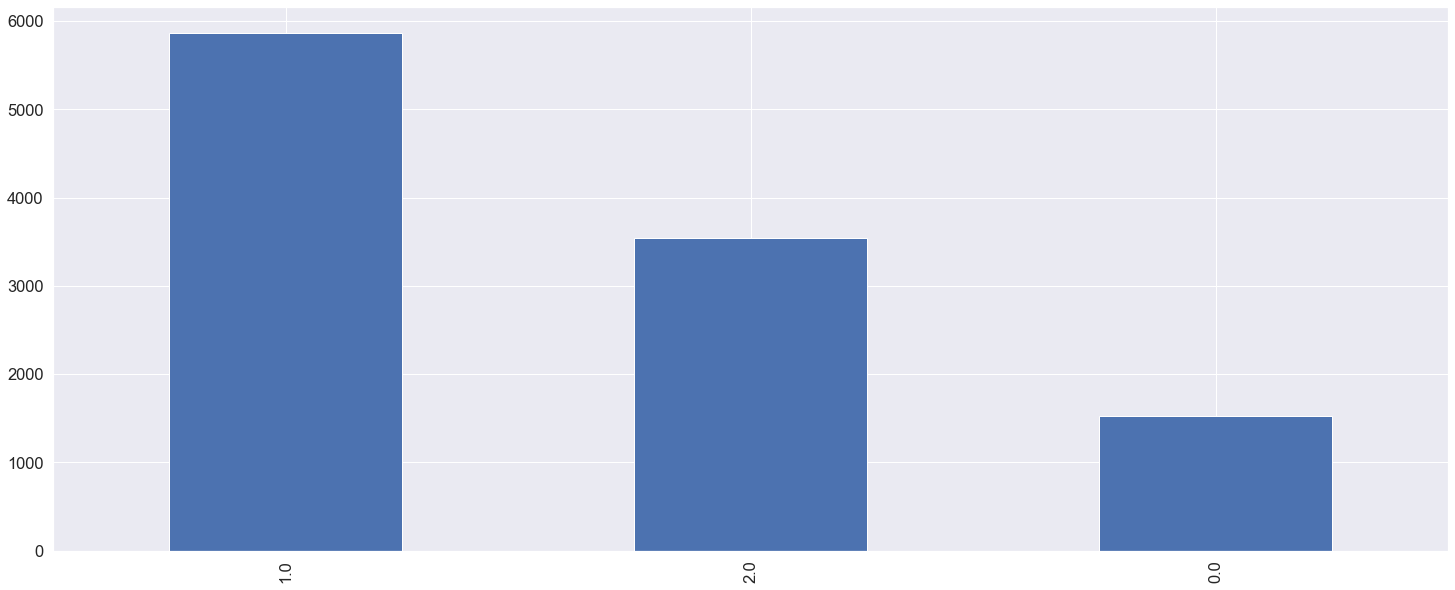

In [170]:
# Plot the distribution of the number of cars
df["Antal_bilar"].value_counts().plot(kind='bar')

df["Antal_bilar"].describe()



## Step 4.2 - Categorical Variables

In [50]:
# Make all dtype int for df_clean
df_clean = df_clean.astype(int)

# Select the numerical variables for correlation analysis
numerical_variables = ['Ålder', 'Antal_barn', 'Antal_vuxna']

# Select the categorical variables for one-hot encoding
categorical_variables = ['Kön', 'Bostadstyp', 'Hushållstyp']

# Perform one-hot encoding but wihtout VIKT_individ
encoded_data = pd.get_dummies(df_clean, columns=categorical_variables)

# Display the encoded data
encoded_data.head()

,Ålder,H0_6år,H7_12år,H13_17år,H18_64år,H_minst65år,Antal_barn,Antal_vuxna,Antal_bilar,Kön_1,Kön_2,Kön_3,Bostadstyp_1,Bostadstyp_2,Bostadstyp_3,Hushållstyp_1,Hushållstyp_2,Hushållstyp_3,Hushållstyp_4,Hushållstyp_5
0,16,0,0,1,3,0,1,3,2,0,1,0,1,0,0,0,0,0,0,1
1,16,0,0,1,2,0,1,2,1,1,0,0,1,0,0,0,0,0,1,0
2,16,0,0,2,2,0,2,2,1,1,0,0,0,1,0,0,0,0,1,0
3,16,0,0,2,3,0,2,3,2,1,0,0,0,1,0,0,0,0,0,1
4,16,0,0,1,4,0,1,4,2,1,0,0,0,1,0,0,0,0,0,1


In [55]:
# rename the encoded data columns to actual categories names
encoded_data = encoded_data.rename(columns={
    "Antal_bilar_0": "No car",
    "Antal_bilar_1": "One car",
    "Antal_bilar_2": "Two cars or more",
    "Kön_1": "Female",
    "Kön_2": "Male",
    "Kön_3": "g_Other",
    "Bostadstyp_1": "Apartment",
    "Bostadstyp_2": "Villa",
    "Bostadstyp_3": "ht_Other",
    "Hushållstyp_1": "Single no child",
    "Hushållstyp_2": "Single with child",
    "Hushållstyp_3": "Couple no child",
    "Hushållstyp_4": "Couple with child",
    "Hushållstyp_5": "hh_Other"})
encoded_data.head()


,Ålder,H0_6år,H7_12år,H13_17år,H18_64år,H_minst65år,Antal_barn,Antal_vuxna,Antal_bilar,Female,Male,g_Other,Apartment,Villa,ht_Other,Single no child,Single with child,Couple no child,Couple with child,hh_Other
0,16,0,0,1,3,0,1,3,2,0,1,0,1,0,0,0,0,0,0,1
1,16,0,0,1,2,0,1,2,1,1,0,0,1,0,0,0,0,0,1,0
2,16,0,0,2,2,0,2,2,1,1,0,0,0,1,0,0,0,0,1,0
3,16,0,0,2,3,0,2,3,2,1,0,0,0,1,0,0,0,0,0,1
4,16,0,0,1,4,0,1,4,2,1,0,0,0,1,0,0,0,0,0,1


In [260]:
# Changing anal_bilar to either 0 or 1, where 0 is no car and 1 is one car or more
encoded_data['Antal_bilar'] = encoded_data['Antal_bilar'].replace([0, 1, 2], [0, 1, 1])

# Display the encoded data
encoded_data.head()


,Ålder,H0_6år,H7_12år,H13_17år,H18_64år,H_minst65år,Antal_barn,Antal_vuxna,Antal_bilar,Female,Male,g_Other,Apartment,Villa,ht_Other,Single no child,Single with child,Couple no child,Couple with child,hh_Other
0,16,0,0,1,3,0,1,3,1,0,1,0,1,0,0,0,0,0,0,1
1,16,0,0,1,2,0,1,2,1,1,0,0,1,0,0,0,0,0,1,0
2,16,0,0,2,2,0,2,2,1,1,0,0,0,1,0,0,0,0,1,0
3,16,0,0,2,3,0,2,3,1,1,0,0,0,1,0,0,0,0,0,1
4,16,0,0,1,4,0,1,4,1,1,0,0,0,1,0,0,0,0,0,1


# Step 4.3 - Scaling continuous variables

In [262]:
# Min max scaling and Standard scaling on Ålder, Antal_barn, Antal_vuxna

# Select the numerical variables for correlation analysis
numerical_variables = ['Ålder', 'Antal_barn', 'Antal_vuxna','H0_6år','H7_12år','H13_17år','H18_64år','H_minst65år']

# Create MinMaxScaler and StandardScaler objects
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Create a copy of the encoded data
encoded_data_scaled = encoded_data.copy()

# Scale the numerical variables

#encoded_data_scaled[numerical_variables] = standard_scaler.fit_transform(encoded_data_scaled[numerical_variables])
encoded_data_scaled[numerical_variables] = min_max_scaler.fit_transform(encoded_data_scaled[numerical_variables])


# Feature Engineering
#encoded_data_scaled['Child_to_Adult'] = encoded_data_scaled['Antal_barn'] / encoded_data_scaled['Antal_vuxna'].replace(0, 0.001)  # Avoid division by zero
#encoded_data_scaled['Elderly_Ratio'] = encoded_data_scaled['H_minst65år'] / (encoded_data_scaled['Antal_barn'] + encoded_data_scaled['Antal_vuxna']).replace(0, 0.001)
#encoded_data_scaled['Gender_Ratio'] = encoded_data_scaled['Female'] / (encoded_data_scaled['Male'] + encoded_data_scaled['Female']).replace(0, 0.001)
#encoded_data_scaled['House_Type'] = encoded_data_scaled['Apartment'] + encoded_data_scaled['Villa']*2 + encoded_data_scaled['ht_Other']*3  # Assuming apartment:1, villa:2, other:3
#encoded_data_scaled['Is_Single'] = ((encoded_data_scaled['Antal_vuxna'] == 1) & (encoded_data_scaled['Antal_barn'] == 0)).astype(int)
#encoded_data_scaled['Total_Members'] = encoded_data_scaled['Antal_barn'] + encoded_data_scaled['Antal_vuxna']


# Display the scaled data
encoded_data_scaled.head()


,Ålder,H0_6år,H7_12år,H13_17år,H18_64år,H_minst65år,Antal_barn,Antal_vuxna,Antal_bilar,Female,Male,g_Other,Apartment,Villa,ht_Other,Single no child,Single with child,Couple no child,Couple with child,hh_Other
0,0.0,0.0,0.0,0.166667,0.375,0.0,0.1,0.250,1,0,1,0,1,0,0,0,0,0,0,1
1,0.0,0.0,0.0,0.166667,0.250,0.0,0.1,0.125,1,1,0,0,1,0,0,0,0,0,1,0
2,0.0,0.0,0.0,0.333333,0.250,0.0,0.2,0.125,1,1,0,0,0,1,0,0,0,0,1,0
3,0.0,0.0,0.0,0.333333,0.375,0.0,0.2,0.250,1,1,0,0,0,1,0,0,0,0,0,1
4,0.0,0.0,0.0,0.166667,0.500,0.0,0.1,0.375,1,1,0,0,0,1,0,0,0,0,0,1


# Correlation between variables


Text(0.1, 0.05, 'Source: NHTS 2017')

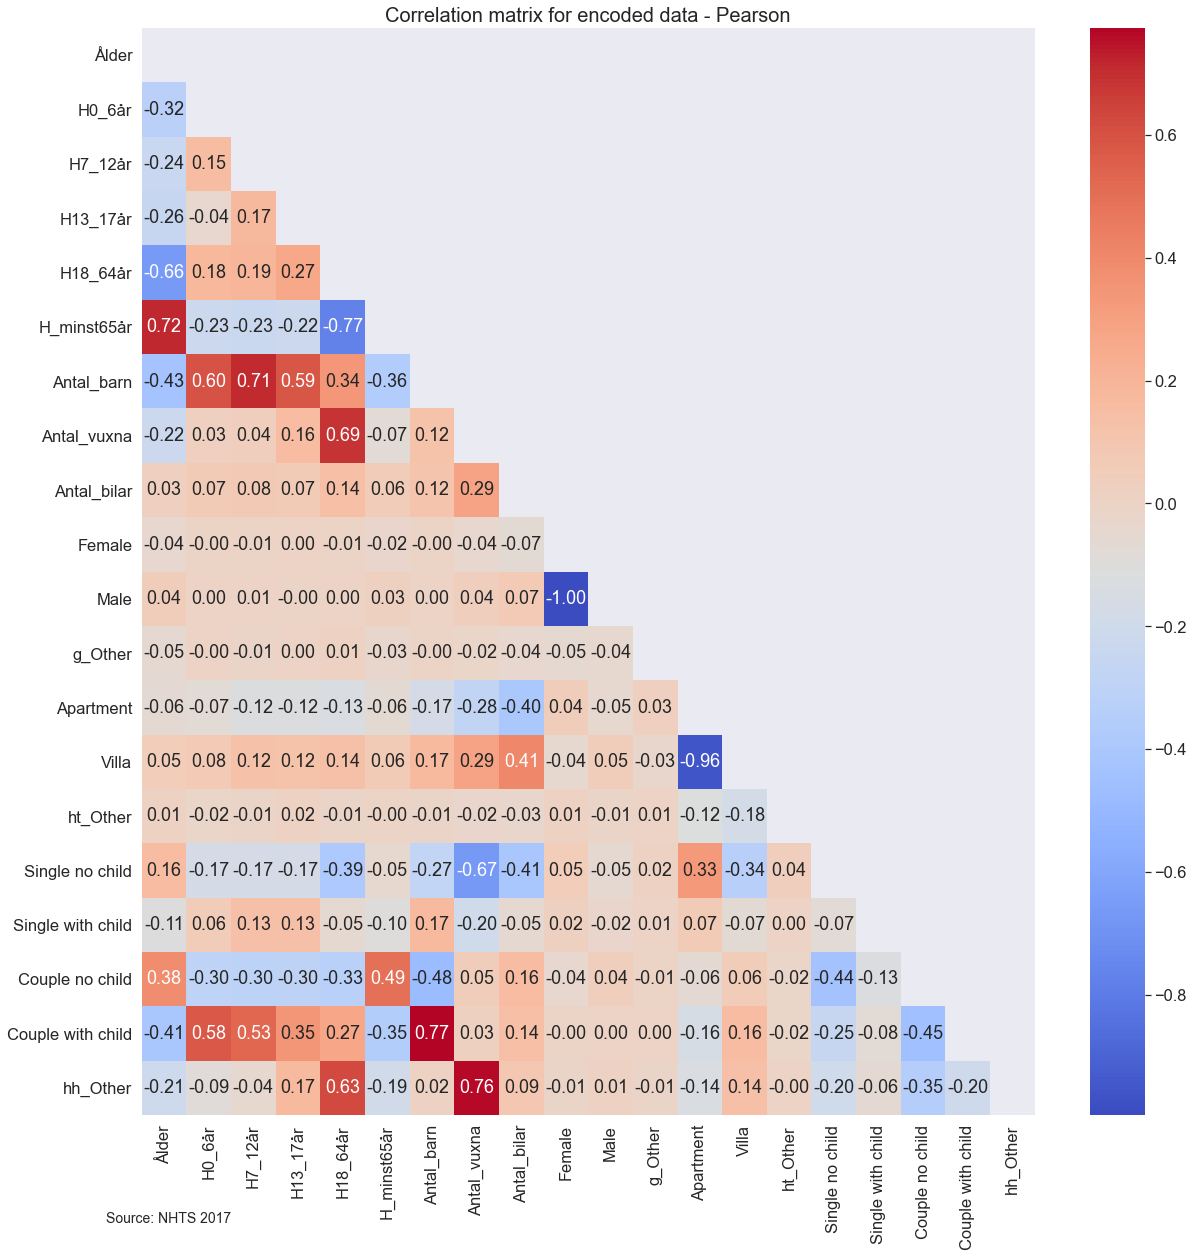

In [263]:
# Correlation matrix for encoded data
correlation_matrix = encoded_data_scaled.corr( method='pearson')

# Plot correlation matrix
plt.figure(figsize=(20, 20))

# Mask upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=np.bool))

# Plot heatmap of correlation matrix
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm')

# Set title
plt.title("Correlation matrix for encoded data - Pearson", fontsize=20)

# Set figure bottom subtitle
plt.figtext(0.1, 0.05, "Source: NHTS 2017", fontsize=14)


# Trying out a regression models

## Splitting training and testing data

In [278]:
data = encoded_data_scaled.copy()

# Select the features (input variables) and the target variable (number of cars)
# Features are all column heads without Antal_bilar
features = [col for col in data.columns if col != 'Antal_bilar']
target = 'Antal_bilar'


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.5, random_state=42)


## Trying out classification models

In [279]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the classifier
clf = RandomForestClassifier(random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

from sklearn.metrics import classification_report, accuracy_score

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8581625183016105

Classification Report:
               precision    recall  f1-score   support

           0       0.51      0.40      0.45       792
           1       0.90      0.94      0.92      4672

    accuracy                           0.86      5464
   macro avg       0.71      0.67      0.68      5464
weighted avg       0.85      0.86      0.85      5464



In [280]:
"""
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [10, 50, 100, 200], # Number of trees in random forest
    'max_features': ['auto', 'sqrt'], # Number of features to consider at every split
    'max_depth': [10, 20, 30, None], # Maximum number of levels in tree
    'min_samples_split': [2, 5, 10], # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4], # Minimum number of samples required at each leaf node
    'bootstrap': [True, False] # Method of selecting samples for training each tree
}

# Initialize Random Forest Classifier
rf = RandomForestClassifier()

# Initialize GridSearch with 5-fold cross validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the grid search model
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Train and predict using the best model
best_grid = grid_search.best_estimator_
best_grid_predictions = best_grid.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, best_grid_predictions))
print("\nClassification Report:\n", classification_report(y_test, best_grid_predictions))
"""



Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 981 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1953 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2560 tasks      | elapsed:  3.3min


Best Parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 10}
Accuracy: 0.8718887262079063

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.34      0.43       792
           1       0.90      0.96      0.93      4672

    accuracy                           0.87      5464
   macro avg       0.75      0.65      0.68      5464
weighted avg       0.85      0.87      0.86      5464



[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed:  3.8min finished


-   `bootstrap=True`: Bootstrapping was found to be beneficial. This means samples are drawn with replacement.
-   `max_depth=10`: The best trees have a maximum depth of 10. This ensures that the trees don't grow too deep and potentially overfit to the training data.
-   `max_features='sqrt'`: This means the number of features to consider when looking for the best split is the square root of the total number of features.
-   `min_samples_leaf=4`: This ensures that a leaf node has at least 4 samples, preventing tiny splits that capture noise in the data.
-   `min_samples_split=5`: A node must have at least 5 samples before it's split.
-   `n_estimators=10`: This refers to the number of trees in the forest. Interestingly, only 10 trees were found to be optimal. Sometimes fewer trees can prevent overfitting and lead to better generalization to the test data.

In [313]:
# Initialize the classifier
model = RandomForestClassifier(random_state=42)

# Train the classifier using the best parameters from grid search
model.set_params(**best_params)
model.fit(X_train, y_train)

from sklearn.metrics import classification_report, accuracy_score

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8706076134699854

Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.37      0.45       792
           1       0.90      0.96      0.93      4672

    accuracy                           0.87      5464
   macro avg       0.74      0.66      0.69      5464
weighted avg       0.85      0.87      0.86      5464



In [312]:
from sklearn.metrics import confusion_matrix

# Assuming you have your predictions in `y_pred` and true labels in `y_test`
cm = confusion_matrix(y_test, y_pred)

# Get per-class accuracy
class_accuracies = cm.diagonal() / cm.sum(axis=1)
for idx, accuracy in enumerate(class_accuracies):
    print(f"Class {idx} accuracy: {accuracy:.2f}")

Class 0 accuracy: 0.37
Class 1 accuracy: 0.96


In [314]:
# Save the model
import joblib
joblib.dump(model, 'models/NHTS_NNC.joblib')


['models/NHTS_NNC.joblib']

In [282]:
importances = best_grid.feature_importances_
importances

array([0.19452545, 0.00876943, 0.01102552, 0.00338504, 0.04150771,
       0.0151708 , 0.01678844, 0.12244971, 0.01309207, 0.00955532,
       0.        , 0.10758914, 0.24865152, 0.00282264, 0.13770078,
       0.00500324, 0.05493227, 0.00308789, 0.00394303])

In [283]:
feature_importances = pd.DataFrame({"Feature": features, "Importance": importances})

In [284]:
sorted_features = feature_importances.sort_values(by="Importance", ascending=False)
print(sorted_features)


              Feature  Importance
12              Villa    0.248652
0               Ålder    0.194525
14    Single no child    0.137701
7         Antal_vuxna    0.122450
11          Apartment    0.107589
16    Couple no child    0.054932
4            H18_64år    0.041508
6          Antal_barn    0.016788
5         H_minst65år    0.015171
8              Female    0.013092
2             H7_12år    0.011026
9                Male    0.009555
1              H0_6år    0.008769
15  Single with child    0.005003
18           hh_Other    0.003943
3            H13_17år    0.003385
17  Couple with child    0.003088
13           ht_Other    0.002823
10            g_Other    0.000000


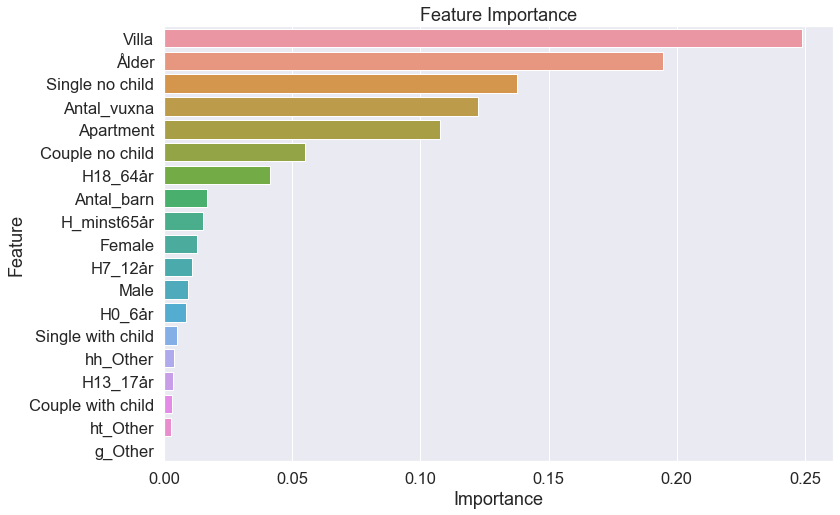

In [285]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,8))
sns.barplot(x="Importance", y="Feature", data=sorted_features)
plt.title('Feature Importance')
plt.show()


In [286]:
from sklearn.metrics import confusion_matrix

# Assuming you have your predictions in `y_pred` and true labels in `y_test`
cm = confusion_matrix(y_test, y_pred)

# Get per-class accuracy
class_accuracies = cm.diagonal() / cm.sum(axis=1)
for idx, accuracy in enumerate(class_accuracies):
    print(f"Class {idx} accuracy: {accuracy:.2f}")

Class 0 accuracy: 0.37
Class 1 accuracy: 0.96


In [287]:
# Trying to predict the number of cars using a neural network
import xgboost as xgb
model = xgb.XGBClassifier(n_estimators=1000, learning_rate=0.05)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Accuracy: 0.8654831625183016

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.33      0.42       792
           1       0.89      0.96      0.92      4672

    accuracy                           0.87      5464
   macro avg       0.73      0.64      0.67      5464
weighted avg       0.85      0.87      0.85      5464



```
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameters and the range of values for each
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
    'n_estimators': [50, 100, 200, 500, 1000],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.5, 0.7, 0.9, 1],
    'colsample_bytree': [0.5, 0.7, 0.9, 1],
    'gamma': [0, 0.25, 0.5, 1],
    'lambda': [0.1, 1, 10],
    'alpha': [0.1, 1, 10]
}

# Initialize XGBClassifier
xgb_model = xgb.XGBClassifier(objective='multi:softprob', eval_metric="mlogloss", use_label_encoder=False)

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model, 
    param_distributions=param_grid, 
    n_iter=100,  # number of parameter settings sampled, adjust as needed
    scoring='accuracy',
    cv=3,  # number of cross-validation folds
    verbose=2,
    random_state=42,
    n_jobs=-1  # use all cores of the machine
)

# Train RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the best parameters and accuracy
print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")
```

Best Parameters: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.2, 'lambda': 0.1, 'gamma': 0.5, 'colsample_bytree': 0.5, 'alpha': 10}
Best Score: 0.582704186684969

In [288]:
from sklearn.metrics import confusion_matrix

# Assuming you have your predictions in `y_pred` and true labels in `y_test`
cm = confusion_matrix(y_test, y_pred)

# Get per-class accuracy
class_accuracies = cm.diagonal() / cm.sum(axis=1)
for idx, accuracy in enumerate(class_accuracies):
    print(f"Class {idx} accuracy: {accuracy:.2f}")

Class 0 accuracy: 0.33
Class 1 accuracy: 0.96


In [290]:
# Train XGBoost with the best hyperparameters
optimal_xgb = xgb.XGBClassifier(
    objective='multi:softprob',
    eval_metric="mlogloss",
    use_label_encoder=False,
    subsample=0.9,
    n_estimators=200,
    max_depth=7,
    learning_rate=0.2,
    reg_lambda=0.1,
    gamma=0.5,
    colsample_bytree=0.5,
    alpha=10
)

optimal_xgb.fit(X_train, y_train)

# Predict on the test set
y_pred = optimal_xgb.predict(X_test)

# Evaluate the model performance
from sklearn.metrics import accuracy_score, classification_report

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


XGBoostError: value 0 for Parameter num_class should be greater equal to 1
num_class: Number of output class in the multi-class classification.

In [291]:
from sklearn.metrics import confusion_matrix

# Assuming you have your predictions in `y_pred` and true labels in `y_test`
cm = confusion_matrix(y_test, y_pred)

# Get per-class accuracy
class_accuracies = cm.diagonal() / cm.sum(axis=1)
for idx, accuracy in enumerate(class_accuracies):
    print(f"Class {idx} accuracy: {accuracy:.2f}")

Class 0 accuracy: 0.33
Class 1 accuracy: 0.96


# Create and train the MLP Regressor using best hyperparameters


In [292]:
# Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
model = GradientBoostingRegressor(learning_rate=0.05, max_depth=4, max_features='sqrt', n_estimators=100, subsample=1.0)
model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=4, max_features='sqrt')

In [293]:
# Evaluate the regressor on the test set
y_pred_GradientBoostingRegressor = model.predict(X_test)

In [294]:
# Print error
print('Mean absolute error:', mean_absolute_error(y_test, y_pred))
# Printing the error
mse = mean_squared_error(y_test, y_pred_GradientBoostingRegressor)
r2 = r2_score(y_test, y_pred_GradientBoostingRegressor)
print('MSE:', mse)
print('R2:', r2)

Mean absolute error: 0.13451683748169838
MSE: 0.08732535266872583
R2: 0.29541447971009327


In [295]:
# Round the predictions to the nearest integer
y_pred_GradientBoostingRegressor = np.round(y_pred_GradientBoostingRegressor)

In [296]:
# Print error after rounding
# Printing the error
mse = mean_squared_error(y_test, y_pred_GradientBoostingRegressor)
r2 = r2_score(y_test, y_pred_GradientBoostingRegressor)
print('MSE:', mse)
print('R2:', r2)

MSE: 0.1271961932650073
R2: -0.026283814169088204


In [297]:
import xgboost
import shap
xgboost_model = xgboost.XGBRegressor().fit(X_train, y_train)
# Evaluate the regressor on the test set
y_pred_XGBRegression = xgboost_model.predict(X_test)

# Print error
print('Mean absolute error:', mean_absolute_error(y_test, y_pred_XGBRegression))
# Printing the error
mse = mean_squared_error(y_test, y_pred_XGBRegression)
r2 = r2_score(y_test, y_pred_XGBRegression)
print('MSE:', mse)
print('R2:', r2)

Mean absolute error: 0.17608216416298586
MSE: 0.09783273043525452
R2: 0.21063559243096297


In [298]:
# Poisson regression
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
# Evaluate the regressor on the test set
y_pred_Poisson_Regression = poisson_model.predict(X_test)

# Print error
print('Mean absolute error:', mean_absolute_error(y_test, y_pred_Poisson_Regression))
# Printing the error
mse = mean_squared_error(y_test, y_pred_Poisson_Regression)
r2 = r2_score(y_test, y_pred_Poisson_Regression)
print('MSE:', mse)
print('R2:', r2)

Mean absolute error: 0.19776352949466824
MSE: 0.09350921823070177
R2: 0.2455198958208482


In [299]:
import statsmodels.api as sm

# Train Poisson regression model
X_train_const = sm.add_constant(X_train)  # adding a constant
poisson_model = sm.GLM(y_train, X_train_const, family=sm.families.Poisson()).fit()

# Predict on test set
X_test_const = sm.add_constant(X_test)
poisson_preds = poisson_model.predict(X_test_const)

# Calculate RMSE
poisson_rmse = mean_squared_error(y_test, poisson_preds, squared=False)
print("Poisson Regression RMSE:", poisson_rmse)


Poisson Regression RMSE: 0.30579692538812947


In [300]:
# Train Negative Binomial model
negative_binomial_model = sm.GLM(y_train, X_train_const, family=sm.families.NegativeBinomial()).fit()

# Predict on test set
nb_preds = negative_binomial_model.predict(X_test_const)

# Calculate RMSE
nb_rmse = mean_squared_error(y_test, nb_preds, squared=False)
print("Negative Binomial Regression RMSE:", nb_rmse)


Negative Binomial Regression RMSE: 0.30602587828454236


In [301]:
from statsmodels.discrete.count_model import ZeroInflatedPoisson

# Train Zero-Inflated Poisson model
zip_model = ZeroInflatedPoisson(y_train, X_train_const).fit(maxiter=500)

# Predict on test set
zip_preds = zip_model.predict(X_test_const)


# Calculate RMSE
zip_rmse = mean_squared_error(y_test, zip_preds, squared=False)
print("Zero-Inflated Poisson Regression RMSE:", zip_rmse)


Inverting hessian failed, no bse or cov_params available
Maximum Likelihood optimization failed to converge. Check mle_retvals


Optimization terminated successfully.
         Current function value: 0.971788
         Iterations: 94
         Function evaluations: 95
         Gradient evaluations: 95
Zero-Inflated Poisson Regression RMSE: 0.3057939139685924


Inverting hessian failed, no bse or cov_params available


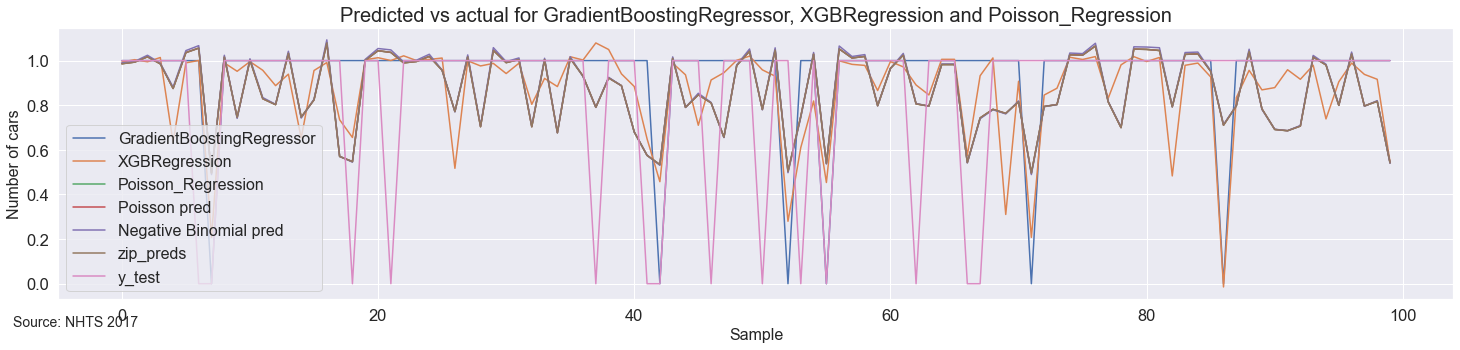

In [302]:
# Plot predicted vs actual using sns for all y_pred models as a lineplot for 100 samples
# Set figure size
plt.figure(figsize=(25, 5))

# Plot predicted vs actual for GradientBoostingRegressor
sns.lineplot(x=range(100), y=y_pred_GradientBoostingRegressor[:100], label='GradientBoostingRegressor')

# Plot predicted vs actual for XGBRegression
sns.lineplot(x=range(100), y=y_pred_XGBRegression[:100], label='XGBRegression')

# Plot predicted vs actual for Poisson_Regression
sns.lineplot(x=range(100), y=y_pred_Poisson_Regression[:100], label='Poisson_Regression')

# Plot predicted vs actual for Poisson pred
sns.lineplot(x=range(100), y=poisson_preds[:100], label='Poisson pred')

# Plot predicted vs actual for Negative Binomial pred
sns.lineplot(x=range(100), y=nb_preds[:100], label='Negative Binomial pred')

# Plot predicted vs actual for zip_preds
sns.lineplot(x=range(100), y=zip_preds[:100], label='zip_preds')

# Plot predicted vs actual for y_test
sns.lineplot(x=range(100), y=y_test[:100], label='y_test')

# Set title
plt.title("Predicted vs actual for GradientBoostingRegressor, XGBRegression and Poisson_Regression", fontsize=20)

# Set figure bottom subtitle
plt.figtext(0.1, 0.05, "Source: NHTS 2017", fontsize=14)

# Set x-axis label
plt.xlabel("Sample", fontsize=16)

# Set y-axis label
plt.ylabel("Number of cars", fontsize=16)

# Set legend
plt.legend(fontsize=16)

# Show plot
plt.show()


In [303]:
# Create a DF of all preds and y_test
df_preds = pd.DataFrame({'y_test': y_test, 'y_pred_GradientBoostingRegressor': y_pred_GradientBoostingRegressor, 'y_pred_XGBRegression': y_pred_XGBRegression, 'y_pred_Poisson_Regression': y_pred_Poisson_Regression, 'nb_preds': nb_preds, 'zip_preds': zip_preds})

# Round all preds to nearest integer
df_preds = df_preds.round()

# Calculate the MSE and R2 for all preds
df_preds_mse = df_preds.apply(lambda col: mean_squared_error(df_preds['y_test'], col))
df_preds_r2 = df_preds.apply(lambda col: r2_score(df_preds['y_test'], col))

# Combine the errors into a DF
df_preds_errors = pd.DataFrame({'MSE': df_preds_mse, 'R2': df_preds_r2})

# Print the errors
df_preds_errors


,MSE,R2
y_test,0.000000,1.000000
y_pred_GradientBoostingRegressor,0.127196,-0.026284
y_pred_XGBRegression,0.136530,-0.101594
y_pred_Poisson_Regression,0.138177,-0.114884
nb_preds,0.135066,-0.089781
zip_preds,0.138177,-0.114884


<AxesSubplot:>

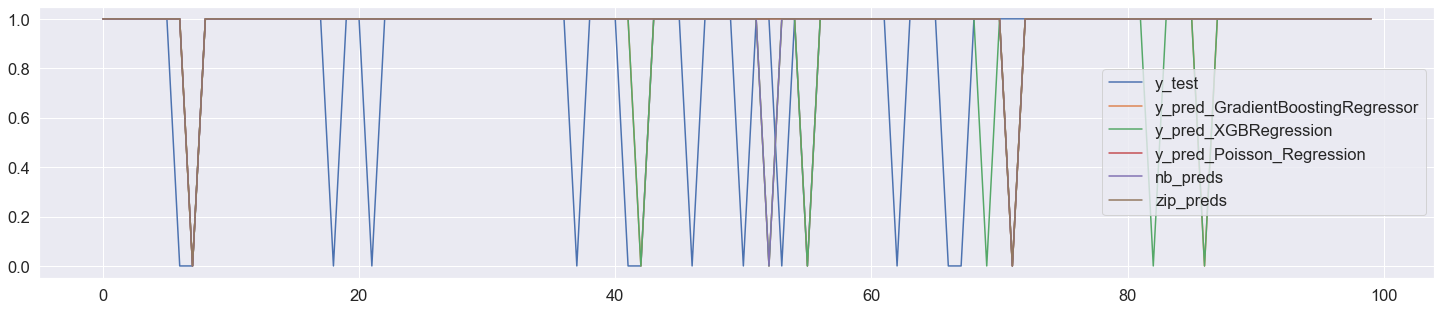

In [304]:
df_preds_plot = df_preds.copy()

# Reset index without keeping the old index
df_preds_plot = df_preds_plot.reset_index(drop=True)

df_preds_plot.head()

df_preds_plot[:100].plot(kind='line', figsize=(25, 5))

In [305]:
explainer = shap.Explainer(xgboost_model)
shap_values = explainer(X_train)

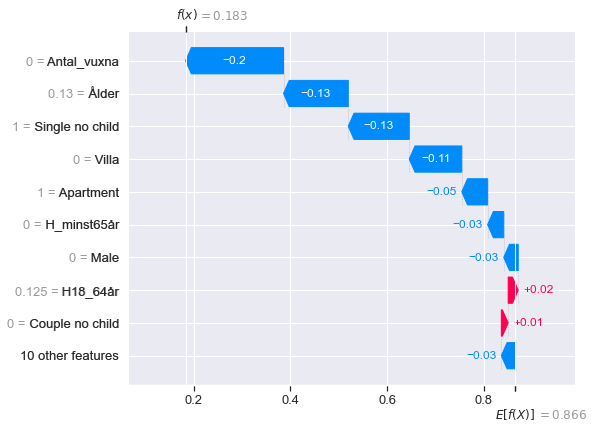

In [306]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])
# visualize the first prediction's explanation with a force plot
shap.plots.force(shap_values[1])

In [22]:
# visualize all the training set predictions
#shap.plots.force(shap_values)

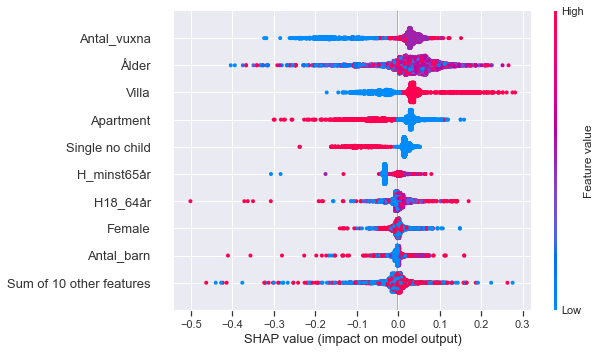

In [307]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

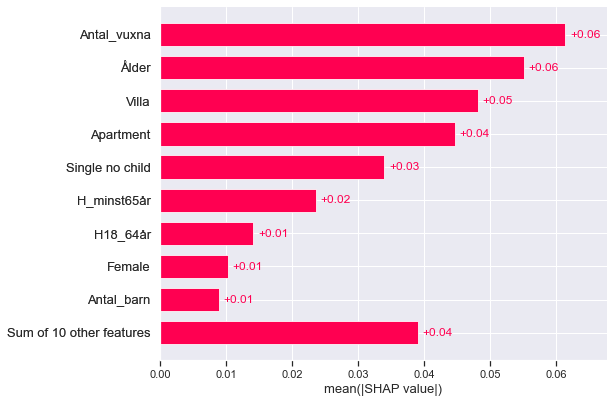

In [308]:
shap.plots.bar(shap_values)

In [25]:
# Save the model
import joblib
joblib.dump(model, 'models/NHTS_NNC.joblib')

# Load the model
classifier = joblib.load('models/NHTS_NNC.joblib')

In [26]:
sample = X_test.sample(1, random_state=556)
sample

,Ålder,H0_6år,H7_12år,H13_17år,H18_64år,H_minst65år,Antal_barn,Antal_vuxna,Female,Male,g_Other,Apartment,Villa,ht_Other,Single no child,Single with child,Couple no child,Couple with child,hh_Other
10331,79,0,0,0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,0


In [27]:
# Sample one observation from test and try to predict the number of cars

# Select one observation from the test set
sample = X_test.sample(1, random_state=42)

# Print the observation
#print(sample)

# Print the actual number of cars
print(y_test.loc[sample.index])

# Predict the number of cars
print(classifier.predict(sample))



4503    1
Name: Antal_bilar, dtype: int32
[1.6819085]


In [28]:
# Pick a random row from the test set

# TODO Check cars per household for diferent neighbourhoods with different distribution of housetypes


In [159]:
# Importing libraries
import joblib
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from tripsender.household import Household

# Load the model
classifier = joblib.load('models/NHTS_NNC.joblib')

# Create a dataframe of people from Person.instances

# Data frame has the following columns
'Ålder', # Age number
'H0_6år', # Number of people in age group 0-6 integer
'H7_12år', # Number of people in age group 7-12 integer
'H13_17år', # Number of people in age group 13-17 integer
'H18_64år', # Number of people in age group 18-64 integer
'H_minst65år', # Number of people in age group 65+ integer
'Antal_barn', # Number of children in household integer
'Antal_vuxna', # Number of adults in household integer
'Female', # Is person female, 1 or 0
'Male', # Is person Male, 1 or 0    
'Other', # Is person other, 1 or 0
'Apartment', # Is household an apartment, 1 or 0
'Villa', # Is household a villa, 1 or 0
'Other', # Is household other, 1 or 0
'Single no child', # Is household a single person without children, 1 or 0
'Single with child', # Is household a single person with children, 1 or 0
'Couple no child', # Is household a couple without children, 1 or 0
'Couple with child', # Is household a couple with children, 1 or 0
'Other' # Is household other, 1 or 0

# for each person in person.instances, calculate the features and add to dataframe

# Create a dataframe of people from Person.instances


persons = []

#Get list of column names
column_names = [
    'Ålder', # Age number
    'H0_6år', # Number of people in age group 0-6 integer
    'H7_12år', # Number of people in age group 7-12 integer
    'H13_17år', # Number of people in age group 13-17 integer
    'H18_64år', # Number of people in age group 18-64 integer
    'H_minst65år', # Number of people in age group 65+ integer
    'Antal_barn', # Number of children in household integer
    'Antal_vuxna', # Number of adults in household integer
    'Female', # Is person female, 1 or 0
    'Male', # Is person Male, 1 or 0    
    'g_Other', # Is person other, 1 or 0
    'Apartment', # Is household an apartment, 1 or 0
    'Villa', # Is household a villa, 1 or 0
    'ht_Other', # Is household other, 1 or 0
    'Single no child', # Is household a single person without children, 1 or 0
    'Single with child', # Is household a single person with children, 1 or 0
    'Couple no child', # Is household a couple without children, 1 or 0
    'Couple with child', # Is household a couple with children, 1 or 0
    'hh_Other' # Is household other, 1 or 0
]

list_of_dicts = []


# Create a list of dictionaries
people = []
person_dict = {}
for household in Household.instances:
    for person in household.members:
        persons.append(person)
        Ålder = person.Alder
        H0_6år = 0
        H7_12år = 0
        H13_17år = 0
        H18_64år = 0
        H_minst65år = 0
        for members in person.household.members:
            if members.Alder < 7:
                H0_6år += 1
            elif members.Alder < 13:
                H7_12år += 1
            elif members.Alder < 18:
                H13_17år += 1
            elif members.Alder < 65:
                H18_64år += 1
            else:
                H_minst65år += 1
        Antal_barn = person.household.children
        Antal_vuxna = len(person.household.members) - person.household.children
        Female,Male,g_other = 0,0,0
        if person.Kon == 'Kvinna':
            Female = 1
        if person.Kon == 'Män':
            Male = 1
        else:
            g_other = 1
        Apartment, Villa, ht_Other = 0,0,0
        if person.household.house_type == 'Apartment':
            Apartment = 1

        elif person.household.house_type == 'Villa':
            Villa = 1
        
        else:
            ht_Other = 1
        Single_no_child, Single_with_child, Couple_no_child, Couple_with_child, hh_Other = 0,0,0,0,0
        if person.household.category == 'Single' and person.household.children == 0:
            Single_no_child = 1
        elif person.household.category == 'Single' and person.household.children > 0:
            Single_with_child = 1
        elif person.household.category == 'Couple' and person.household.children == 0:
            Couple_no_child = 1
        elif person.household.category == 'Couple' and person.household.children > 0:
            Couple_with_child = 1
        else:
            hh_Other = 1
        # Add person to dataframe
        person_dict = {
            'Ålder': Ålder,
            'H0_6år': H0_6år,
            'H7_12år': H7_12år,
            'H13_17år': H13_17år,
            'H18_64år': H18_64år,
            'H_minst65år': H_minst65år,
            'Antal_barn': Antal_barn,
            'Antal_vuxna': Antal_vuxna,
            'Female': Female,
            'Male': Male,
            'g_Other': g_other,
            'Apartment': Apartment,
            'Villa': Villa,
            'ht_Other': ht_Other,
            'Single no child': Single_no_child,
            'Single with child': Single_with_child,
            'Couple no child': Couple_no_child,
            'Couple with child': Couple_with_child,
            'hh_Other': hh_Other
        }
        list_of_dicts.append(person_dict)


# Create a dataframe from the list of dictionaries  
df = pd.DataFrame(list_of_dicts)

print (df.head())

# Select the numerical variables for correlation analysis
numerical_variables = ['Ålder', 'Antal_barn', 'Antal_vuxna','H0_6år','H7_12år','H13_17år','H18_64år','H_minst65år']

# Create MinMaxScaler and StandardScaler objects
min_max_scaler = MinMaxScaler()
standard_scaler = StandardScaler()

# Create a copy of the encoded data
encoded_data_scaled = df.copy()

# Scale the numerical variables

encoded_data_scaled[numerical_variables] = standard_scaler.fit_transform(encoded_data_scaled[numerical_variables])
encoded_data_scaled[numerical_variables] = min_max_scaler.fit_transform(encoded_data_scaled[numerical_variables])

# Predict the number of cars for each person
df['Cars'] = classifier.predict(df)

# Add the number of cars to each person
for i in range(len(df)):
    persons[i].hasCar = df['Cars'][i]

# Add the number of cars to each household
for household in Household.instances:
    household.cars = 0
    for person in household.members:
        household.cars += person.hasCar

Empty DataFrame
Columns: []
Index: []


KeyError: "None of [Index(['Ålder', 'Antal_barn', 'Antal_vuxna', 'H0_6år', 'H7_12år', 'H13_17år',\n       'H18_64år', 'H_minst65år'],\n      dtype='object')] are in the [columns]"

1.  First, we define the desired total number of cars in the neighborhood as `estimated_total_cars` (2689 in this case).
2.  We iterate over each household in the `Household.instances` (assuming it represents a collection of households) to perform the scaling.
3.  For each household, we calculate a scale factor by dividing the `estimated_total_cars` by the sum of cars across all households. This scale factor represents the adjustment needed to match the desired total number of cars.
4.  We multiply the current number of cars in the household by the scale factor to obtain the scaled-down number of cars. Since the result may be a floating-point number, we convert it to an integer using the `int()` function.
5.  Finally, we update the number of cars in the household with the scaled-down value.

In [156]:
# Probabilistic sampling


# Load car_counts json data\processed\NHTS\car_counts.json
import json

def assign_cars_to_households_p():
    with open('data/processed/NHTS/car_counts.json') as json_file:
        car_counts = json.load(json_file)
    nhts_household_count = car_counts
    # Store probabilities into variables

    # Store 0,1,2 car probabilities for each household type
    p_child_villa = [car_counts['child_villa']['0_car'], car_counts['child_villa']['1_car'], car_counts['child_villa']['2_cars']]
    p_child_apartment = [car_counts['child_apartment']['0_car'], car_counts['child_apartment']['1_car'], car_counts['child_apartment']['2_cars']]
    p_no_child_villa = [car_counts['no_child_villa']['0_car'], car_counts['no_child_villa']['1_car'], car_counts['no_child_villa']['2_cars']]
    p_no_child_apartment = [car_counts['no_child_apartment']['0_car'], car_counts['no_child_apartment']['1_car'], car_counts['no_child_apartment']['2_cars']]

    # Print probabilities
    """
    print("Probabilities of number of cars in each household type from NHTS data")
    print(p_child_villa)
    print(p_child_apartment)
    print(p_no_child_villa)
    print(p_no_child_apartment)
    """
    sum_of_counts = 0
    dist_of_households_scb = []
    for item in car_counts:
        sum_of_counts += car_counts[item]["total_households"]
    # print("Distribution of households in the neighbourhood from NHTS data")
    for item in car_counts:
        # print (item, car_counts[item]["total_households"]*100/sum_of_counts)
        dist_of_households_scb.append(car_counts[item]["total_households"]*100/sum_of_counts)

    # Get households with children and housetype villa
    households_w_children_villa = [household for household in Household.instances if household.children > 0 and household.house_type == 'Villa']
    # Get households with children and housetype apartment
    households_w_children_apartment = [household for household in Household.instances if household.children > 0 and household.house_type == 'Apartment']

    # Get households without children and housetype villa
    households_wo_children_villa = [household for household in Household.instances if household.children == 0 and household.house_type == 'Villa']
    # Get households without children and housetype apartment
    households_wo_children_apartment = [household for household in Household.instances if household.children == 0 and household.house_type == 'Apartment']

    list_of_synth_households = [
        households_w_children_villa,
        households_w_children_apartment,
        households_wo_children_villa,
        households_wo_children_apartment
        ]

    # "Distribution of households in the neighbourhood from synth data
    dist_of_households_synth = []
    sum_of_synth_counts = sum([len(item) for item in list_of_synth_households])
    for item in list_of_synth_households:
        # print (len(item)*100/sum_of_synth_counts)
        dist_of_households_synth.append(len(item)*100/sum_of_synth_counts)

    # Getting the estimated number of cars in the neighbourhood based on probability

    household_count = {}
    household_count["child_villa"] = {}
    household_count["child_apartment"] = {}
    household_count["no_child_villa"] = {}
    household_count["no_child_apartment"] = {}

    # Get number of households in the neighbourhood from list_of_synth_households
    household_count["child_villa"]["total_households"] = len(households_w_children_villa)
    household_count["child_apartment"]["total_households"] = len(households_w_children_apartment)
    household_count["no_child_villa"]["total_households"] = len(households_wo_children_villa)
    household_count["no_child_apartment"]["total_households"] = len(households_wo_children_apartment)

    # Get number of cars in the neighbourhood from probabilities
    household_count["child_villa"]["0 car"] = p_child_villa[0]*household_count["child_villa"]["total_households"]
    household_count["child_villa"]["1 car"] = p_child_villa[1]*household_count["child_villa"]["total_households"]
    household_count["child_villa"]["2 cars"] = p_child_villa[2]*household_count["child_villa"]["total_households"]
    # Add total cars in the neighbourhood
    household_count["child_villa"]["total_cars"] = household_count["child_villa"]["1 car"] + household_count["child_villa"]["2 cars"]

    household_count["child_apartment"]["0 car"] = p_child_apartment[0]*household_count["child_apartment"]["total_households"]
    household_count["child_apartment"]["1 car"] = p_child_apartment[1]*household_count["child_apartment"]["total_households"]
    household_count["child_apartment"]["2 cars"] = p_child_apartment[2]*household_count["child_apartment"]["total_households"]
    # Add total cars in the neighbourhood
    household_count["child_apartment"]["total_cars"] = household_count["child_apartment"]["1 car"] + household_count["child_apartment"]["2 cars"]

    household_count["no_child_villa"]["0 car"] = p_no_child_villa[0]*household_count["no_child_villa"]["total_households"]
    household_count["no_child_villa"]["1 car"] = p_no_child_villa[1]*household_count["no_child_villa"]["total_households"]
    household_count["no_child_villa"]["2 cars"] = p_no_child_villa[2]*household_count["no_child_villa"]["total_households"]
    # Add total cars in the neighbourhood
    household_count["no_child_villa"]["total_cars"] = household_count["no_child_villa"]["1 car"] + household_count["no_child_villa"]["2 cars"]

    household_count["no_child_apartment"]["0 car"] = p_no_child_apartment[0]*household_count["no_child_apartment"]["total_households"]
    household_count["no_child_apartment"]["1 car"] = p_no_child_apartment[1]*household_count["no_child_apartment"]["total_households"]
    household_count["no_child_apartment"]["2 cars"] = p_no_child_apartment[2]*household_count["no_child_apartment"]["total_households"]
    # Add total cars in the neighbourhood
    household_count["no_child_apartment"]["total_cars"] = household_count["no_child_apartment"]["1 car"] + household_count["no_child_apartment"]["2 cars"]


    synth_household_count = household_count
    """
    print(json.dumps(household_count, indent=4, sort_keys=True))
    """

    cars_in_neighbourhood = 10000

    # Assign cars to households based on probabilities and remove cars from neighbourhood

    for household in households_w_children_villa:
        if cars_in_neighbourhood > 0:
            car_to_assign = random.choices([0,1,2], weights=[p_child_villa[0], p_child_villa[1], p_child_villa[2]])[0]
            household.cars = car_to_assign
            cars_in_neighbourhood -= car_to_assign
        else:
            print("Ran out of cars in neighbourhood")
            break
    """
    # Print number of households 
    print(f"Number of households_w_children_villa: {len(households_w_children_villa)}")
    #Print how many cars were assigned to households
    print(f"Number of cars assigned to households households_w_children_villa: {sum([household.cars for household in households_w_children_villa])}")
    print(f"Number of cars in neighbourhood after households_w_children_villa: {cars_in_neighbourhood}")
    print("___________________________________________________________")
    """
    for household in households_w_children_apartment:
        if cars_in_neighbourhood > 0:
            car_to_assign = random.choices([0,1,2], weights=[p_child_apartment[0], p_child_apartment[1], p_child_apartment[2]])[0]
            household.cars = car_to_assign
            cars_in_neighbourhood -= car_to_assign
        else:
            print("Ran out of cars in neighbourhood")
            break
    """
    # Print number of households 
    print(f"Number of households_w_children_apartment: {len(households_w_children_apartment)}")
    #Print how many cars were assigned to households
    print(f"Number of cars assigned to households with children and housetype villa: {sum([household.cars for household in households_w_children_apartment])}")
    print(f"Number of cars in neighbourhood after households_w_children_apartment: {cars_in_neighbourhood}")
    print("___________________________________________________________")
    """
    for household in households_wo_children_villa:
        if cars_in_neighbourhood > 0:
            car_to_assign = random.choices([0,1,2], weights= [p_no_child_villa[0], p_no_child_villa[1], p_no_child_villa[2]])[0]
            household.cars = car_to_assign
            cars_in_neighbourhood -= car_to_assign
        else:
            print("Ran out of cars in neighbourhood")
            break
    """
    # Print number of households 
    print(f"Number of households_wo_children_villa: {len(households_wo_children_villa)}")
    #Print how many cars were assigned to households
    print(f"Number of cars assigned to households with children and housetype villa: {sum([household.cars for household in households_wo_children_villa])}")
    print(f"Number of cars in neighbourhood after households_wo_children_villa: {cars_in_neighbourhood}")
    print("___________________________________________________________")
    """
    for household in households_wo_children_apartment:
        if cars_in_neighbourhood > 0:
            car_to_assign = random.choices([0,1,2], weights=[p_no_child_apartment[0], p_no_child_apartment[1], p_no_child_apartment[2]])[0]
            household.cars = car_to_assign
            cars_in_neighbourhood -= car_to_assign
        else:
            print("Ran out of cars in neighbourhood")
            break
    """
    # Print number of households 
    print(f"Number of households_wo_children_apartment: {len(households_wo_children_apartment)}")
    #Print how many cars were assigned to households
    print(f"Number of cars assigned to households_wo_children_apartment: {sum([household.cars for household in households_wo_children_apartment])}")
    print(f"Number of cars in neighbourhood after households_wo_children_apartment: {cars_in_neighbourhood}")
    print("___________________________________________________________")
    """